## Network-level analysis of the results for the paper "Negotiating Comfort: Simulating Personality-Driven LLM Agents in Shared Residential Social Networks"

In [ ]:
# Step 1: Mount Google Drive to access the simulation results
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Step 2: Switch to the simulation directory
import sys
#%cd /content/drive/My Drive/Crowd_Related_Work/crowd_projects/energy_sim_1/results/2025-05-13=14-34-43-377
%cd /content/drive/My Drive/Crowd_Related_Work/crowd_projects/energy_sim_1/results/2025-05-13=14-34-03-754

In [ ]:
# Step 3: Import the required libraries
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
# Step 4: Load the data files needed depending on the type of analysis

# Load the dataset for all days
data_files = [os.path.join(os.getcwd(), f"simulation_data_day_{day}_all.csv") for day in range(15)]
# data_files.extend([
#     os.path.join("/content/drive/My Drive/Crowd_Related_Work/crowd_projects/energy_sim_1/results/2025-05-13=14-34-03-754", f"simulation_data_day_{day}_all.csv")
#     for day in range(30)
# ])

df_list = []

for file in data_files:
    day_data = pd.read_csv(file)
    first_row_df = pd.DataFrame([day_data.iloc[0]])  # Convert first row to single-row DataFrame
    first_row_df['group'] = 'fifty_percent'
    first_row_df['network_day'] = int(file.split('_')[-2])
    df_list.append(first_row_df)

df = pd.concat(df_list, ignore_index=True)

# Load 100% positive data
pos100_df = pd.read_csv("/content/drive/My Drive/Crowd_Related_Work/crowd_projects/energy_sim_1/results/2025-05-19=04-30-39-778/pos_100_network_level.csv")
pos100_df['group'] = 'all_positive'
pos100_df['network_day'] = range(0, 15)

# Load 0% positive data
pos0_df = pd.read_csv("/content/drive/My Drive/Crowd_Related_Work/crowd_projects/energy_sim_1/results/2025-05-19=04-31-25-891/pos_0_network_level.csv")
pos0_df['group'] = 'all_negative'
pos0_df['network_day'] = range(0, 15)

# Append the network-level CSVs properly using pd.concat
df = pd.concat([
    df,
    pos100_df,
    pos0_df], ignore_index=True)


In [ ]:
network_level_df =  df[[col for col in df.columns if col.startswith("network_")]].copy()

# Drop "network_current_day" if it's present
network_level_df = network_level_df.drop(columns=["network_current_day"], errors='ignore')

In [ ]:
# Step 5: Finding a regression line to show the trends with different trait distributions, results provided in Table 2 of the paper

def run_slopes_all_metrics(df, metrics):
    results = {}
    for metric in metrics:
        metric_results = {}
        for group in df['group'].unique():
            subset = df[df['group'] == group]
            X = sm.add_constant(subset['network_day'])
            y = subset[metric]
            model = sm.OLS(y, X).fit()
            metric_results[group] = {
                'slope': model.params['network_day'],
                'stderr': model.bse['network_day'],
                'pvalue': model.pvalues['network_day'],
            }
        results[metric] = metric_results
    return results

In [ ]:
metrics = [
    'network_avg_weighted_degree',
    'network_avg_friendship_weight',
    'network_strong_friendships',
    'network_degree_outside',
    'network_temperature_set',
    'network_cost',
    'network_avg_happiness_level',
    'network_cost_happ_ratio'
]

slope_results = run_slopes_all_metrics(df, metrics)

# Print the results, formatted for easy comparison 
for metric, groups in slope_results.items():
    print(f"\n📊 {metric}")
    for group, res in groups.items():
        star = (
            "***" if res['pvalue'] < 0.001 else
            "**" if res['pvalue'] < 0.01 else
            "*" if res['pvalue'] < 0.05 else ""
        )
        print(f"  {group:15}: Slope = {res['slope']:.4f}, StdErr = {res['stderr']:.4f}, P = {res['pvalue']:.4f} {star}")



📊 network_avg_weighted_degree
  fifty_percent  : Slope = -0.0666, StdErr = 0.0404, P = 0.1232 
  all_positive   : Slope = 0.1368, StdErr = 0.0273, P = 0.0002 ***
  all_negative   : Slope = -0.1355, StdErr = 0.0272, P = 0.0003 ***

📊 network_avg_friendship_weight
  fifty_percent  : Slope = -0.0145, StdErr = 0.0088, P = 0.1232 
  all_positive   : Slope = 0.0298, StdErr = 0.0059, P = 0.0002 ***
  all_negative   : Slope = -0.0295, StdErr = 0.0059, P = 0.0003 ***

📊 network_strong_friendships
  fifty_percent  : Slope = 0.0214, StdErr = 0.1648, P = 0.8985 
  all_positive   : Slope = 1.0786, StdErr = 0.2021, P = 0.0001 ***
  all_negative   : Slope = -0.0464, StdErr = 0.1381, P = 0.7420 

📊 network_degree_outside
  fifty_percent  : Slope = 0.7750, StdErr = 0.1729, P = 0.0006 ***
  all_positive   : Slope = 0.7750, StdErr = 0.1729, P = 0.0006 ***
  all_negative   : Slope = 0.7750, StdErr = 0.1729, P = 0.0006 ***

📊 network_temperature_set
  fifty_percent  : Slope = 0.0000, StdErr = 0.0000, P = 

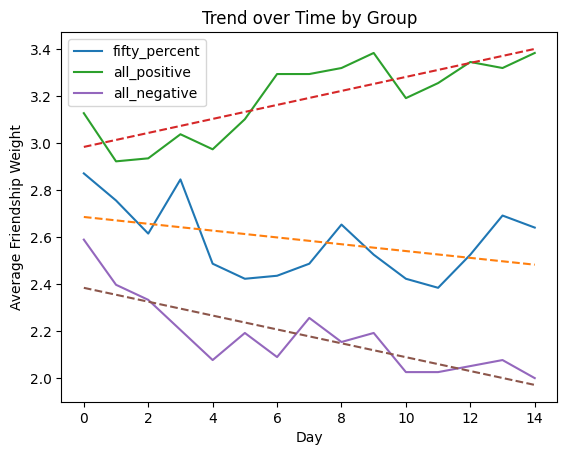

In [ ]:
# A chart demonstrating trend over time by group
for group in df['group'].unique():
    subset = df[df['group'] == group]
    plt.plot(subset['network_day'], subset['network_avg_friendship_weight'], label=group)
    model = sm.OLS(subset['network_avg_friendship_weight'], sm.add_constant(subset['network_day'])).fit()
    plt.plot(subset['network_day'], model.predict(sm.add_constant(subset['network_day'])), linestyle='--')

plt.xlabel('Day')
plt.ylabel('Average Friendship Weight')
plt.title('Trend over Time by Group')
plt.legend()
plt.show()


In [ ]:
# Step 6: OLS Regression to analyze the influence of network-level variables on average happiness level.

import statsmodels.api as sm
# import statsmodels.formula.api as smf

# Example: Predicting average happiness level using the average friendship weight
# In the paper, we provide regression results of predicting average happiness level using degree outside
X = network_level_df[[
        "network_avg_friendship_weight"
        ]]
y = network_level_df["network_avg_happiness_level"]

# Add constant for intercept
X = sm.add_constant(X)

model = sm.OLS(y, X).fit(cov_type='HC3')
print(model.summary())


                                 OLS Regression Results                                
Dep. Variable:     network_avg_happiness_level   R-squared:                       0.792
Model:                                     OLS   Adj. R-squared:                  0.788
Method:                          Least Squares   F-statistic:                     211.0
Date:                         Tue, 20 May 2025   Prob (F-statistic):           5.58e-21
Time:                                 09:58:17   Log-Likelihood:                -81.382
No. Observations:                           60   AIC:                             166.8
Df Residuals:                               58   BIC:                             171.0
Df Model:                                    1                                         
Covariance Type:                           HC3                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
----------------------

In [ ]:
# Print p-values with full float precision
for variable, pval in model.pvalues.items():
    print(f"{variable}: {pval:.30f}")


const: 0.000000000000000000000000000000
network_avg_friendship_weight: 0.000000000000000000000000000000
network_degree_outside: 0.000763327637756799253290762586


In [ ]:
# Step 7: Save the results
with open("ols_results_network_level_10.txt", "w") as f:
    f.write(model.summary().as_text())

In [ ]:
# Optional tests: Breusch-Pagan test to detect heteroskedasticity

from statsmodels.stats.diagnostic import het_breuschpagan

# Perform Breusch-Pagan test
bp_test = het_breuschpagan(model.resid, model.model.exog)

bp_stat = bp_test[0]
bp_pval = bp_test[1]

print(f"\nBreusch-Pagan test statistic: {bp_stat:.4f}")
print(f"P-value: {bp_pval:.4f}")

if bp_pval < 0.05:
    print("=> Heteroskedasticity detected (variance is not constant)")
else:
    print("=> No evidence of heteroskedasticity (variance is constant)")



Breusch-Pagan test statistic: 1.2688
P-value: 0.5303
=> No evidence of heteroskedasticity (variance is constant)


In [ ]:
# VIF test
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

formula = """
network_avg_happiness_level ~  network_avg_friendship_weight + network_degree_outside

"""

# Use Patsy to create design matrices
y, X = dmatrices(formula, df, return_type='dataframe')

# Drop intercept to avoid it skewing VIF
X = X.drop('Intercept', axis=1)

# Compute VIF
vif_data = pd.DataFrame({
    'Variable': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})

print(vif_data)


                        Variable       VIF
0  network_avg_friendship_weight  1.228025
1         network_degree_outside  1.228025


In [ ]:
# Correlations
print(df[[
    "network_avg_friendship_weight",
    "network_degree_outside",
    # "network_temperature_set",
    # "network_cost"
]].corr())

                               network_avg_friendship_weight  \
network_avg_friendship_weight                       1.000000   
network_degree_outside                             -0.011849   

                               network_degree_outside  
network_avg_friendship_weight               -0.011849  
network_degree_outside                       1.000000  
